In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
from tensorflow import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import optimizers, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics
from tensorflow.keras.utils import to_categorical

# Import the clean_datas

In [ ]:
df = pd.DataFrame()

APP_FOLDER = 'drive/MyDrive/images/'

file_type = ['jpg', 'peg', 'JPG']
product_name = []
img_numpy_array = []
max_img = 35  #so every img has the same weight (maximizing the number training size)

### Clean the inputs ###

# First step : create a copy of png images into jpeg (to reduce the size and so the memory size which will be necessary to convert to numpy arrays)
for files in os.walk(APP_FOLDER):
    for img in files[2]:
        if img[-3:] == 'png':
            # In case images would be truncated
            ImageFile.LOAD_TRUNCATED_IMAGES = True
            # importing the image
            image = Image.open(f"{files[0]}/{img}")
            # converting to jpg
            rgb_im = image.convert("RGB")
            # create a copy in jpeg
            rgb_im.save(f"{files[0]}/{img[:-3]}_jpeg", "jpeg")

# Second step : clean the data :
for files in os.walk(APP_FOLDER):
    counter = 0
    for img in files[2]:
        if img[-3:] in file_type and counter < max_img:
            pdt_name = files[0].replace('drive/MyDrive/images/', '')
            product_name.append(pdt_name)

            # importing the image
            image = Image.open(f"{files[0]}/{img}")

            # Resize in 1024 x 1024
            image = image.resize((1024, 1024))

            # Input the image as numpy array into img_numpy_array
            img_numpy_array.append(np.asarray(image))
            counter += 1
        else:
            pass

#  Set the features
df["product_name"] = product_name
df["img_numpy_array"] = img_numpy_array

# Dropout products without enough images
min_img_per_product = 15
products_with_enough_img = list(
    df.groupby('product_name').count()[df.groupby('product_name').count(
    )["img_numpy_array"] > min_img_per_product].index)
df = df[df["product_name"].isin(products_with_enough_img) == True]

### Preprocess the data ###

# Create a dictionary from each product name to encode them
products_encoded = {}
counter = 0

list_of_products_kept = sorted(list(df["product_name"].unique()))

for products in list_of_products_kept:
    products_encoded[products] = counter
    counter += 1

# Generate y by matching the product_name serie to the encoded dictionary
y = []
for product_name in df["product_name"]:
    for product, code in products_encoded.items():
        if product == product_name:
            y.append(code)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
products_encoded

{'ananas': 0,
 'aubergine': 1,
 'banane': 2,
 'brocoli': 3,
 'carotte': 4,
 'citron': 5,
 'concombre': 6,
 'gingembre': 7,
 'melon': 8,
 'pasteque': 9,
 'poivron': 10,
 'pomme_de_terre': 11,
 'raisin': 12,
 'salade': 13,
 'tomate': 14}

In [ ]:
shape_dict = {}
for arrays in df["img_numpy_array"]:
  if arrays.shape in shape_dict:
    shape_dict[arrays.shape] += 1
  else:
    shape_dict[arrays.shape] = 1

In [ ]:
shape_dict

{(1024, 1024, 3): 486}

In [ ]:
df["arrays_shape"] = [arrays.shape for arrays in df["img_numpy_array"]]
df = df.drop(df[df["arrays_shape"]!=(1024,1024,3)].index)
img_numpy_array_to_list = df["img_numpy_array"].to_list()

In [ ]:
# Create X, a numpy array of images kept
X = np.asarray(img_numpy_array_to_list)

In [ ]:
# Transform y into a numpy array (y_cat)
num_classes = len(list_of_products_kept)
y_cat = to_categorical(y, num_classes)

In [ ]:
# Shuffle X and y
p = list(np.random.permutation(len(X)))
X = X[p]
y_cat = y_cat[p]

In [ ]:
# Generate X and y test, val and train
# X and y test will be about 17% of the dataset
first_split = int(len(y) / 6.)

# X and y val will be about 37% of the dataset
second_split = first_split + int(len(y) * 0.2)

# And so, X and y train will be the last 63%
X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[
    second_split:]
y_test, y_val, y_train = y_cat[:first_split], y_cat[
    first_split:second_split], y_cat[second_split:]

In [ ]:
print(X_test.shape, X_val.shape, X_train.shape)

(81, 1024, 1024, 3) (97, 1024, 1024, 3) (308, 1024, 1024, 3)


In [ ]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Compute the baseline

In [ ]:
#((1/num_classes)*(nbre_images_du_produit/nombre_total_images))+((1/num_classes)*(nbre_images_du_produit/nombre_total_images))+...

In [ ]:
baseline = 1/num_classes
print(f"la baseline est de {round(baseline*100,2)}%")

la baseline est de 6.67%


# Save the datas to use it back if necessary

In [ ]:
model_path = 'drive/MyDrive/vgg16_selection_images_1024'
np.save(os.path.join(model_path, "X_test.npy"), X_test)
np.save(os.path.join(model_path, "X_val.npy"), X_val)
np.save(os.path.join(model_path, "X_train.npy"), X_train)
np.save(os.path.join(model_path, "y_test.npy"), y_test)
np.save(os.path.join(model_path, "y_val.npy"), y_val)
np.save(os.path.join(model_path, "y_train.npy"), y_train)

# Load datas

In [ ]:
model_path = 'drive/MyDrive/vgg16_selection_images_1024'
X_test = np.load(os.path.join(model_path, "X_test.npy"))
X_train = np.load(os.path.join(model_path, "X_train.npy"))
X_val = np.load(os.path.join(model_path, "X_val.npy"))
y_test = np.load(os.path.join(model_path, "y_test.npy"))
y_val = np.load(os.path.join(model_path, "y_val.npy"))
y_train = np.load(os.path.join(model_path, "y_train.npy"))

In [ ]:
first_numpy_to_test_api = X_test[0]
np.save(os.path.join(model_path, "first_numpy_to_test_api.npy"), first_numpy_to_test_api)

In [ ]:
X_train.shape

(308, 1024, 1024, 3)

In [ ]:
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

# Define the home_made_moel

In [ ]:
# input_shape_ = X_train[0].shape

# model = models.Sequential()
# model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape_))
# model.add(layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
# model.add(layers.MaxPooling2D(pool_size=(3, 3)))
# model.add(layers.Dropout(0.1))
# model.add(layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
# model.add(layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(layers.Dropout(0.3))
# model.add(layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
# model.add(layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(layers.Dropout(0.2))
# model.add(layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
# model.add(layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# # model.add(layers.Dropout(0.1))
# model.add(layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))
# model.add(layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# # model.add(layers.Dropout(0.2))
# model.add(layers.Flatten())
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(0.25))
# model.add(layers.Dense(num_classes, activation='softmax'))

# # learning_rate=1e-4
# opt = optimizers.Adam(learning_rate=0.1)
# model.compile(loss='categorical_crossentropy',
#               optimizer=opt,
#               metrics=[metrics.Precision()])

# model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 256, 256, 256)     7168      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 256, 256, 256)     590080    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 85, 85, 256)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 85, 85, 256)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 85, 85, 128)       295040    
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 85, 85, 128)       147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 42, 42, 128)      

In [ ]:
# from tensorflow.keras.callbacks import LearningRateScheduler
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.
# def scheduler(epoch, lr):
#   if epoch < 10:
#     return lr
#   else:
#     return lr * tf.math.exp(-0.1)

# callback = LearningRateScheduler(scheduler)

In [ ]:
# es = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)

# history = model.fit(X_train, y_train, 
#                     validation_data=(X_val, y_val), 
#                     epochs=50, 
#                     batch_size=8, 
#                     callbacks=[es])

# Define the ResNet50_model

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape = X_train[0].shape)
base_model.trainable = False
flatten_layer = layers.Flatten()
first_dense_layer = layers.Dense(128, activation='relu')
first_dropout_layer = layers.Dropout(0.5)
second_dense_layer = layers.Dense(64, activation='relu')
second_dropout_layer = layers.Dropout(0.3)
prediction_layer = layers.Dense(num_classes, activation='softmax')

model = models.Sequential([
    base_model,
    flatten_layer,
    first_dense_layer,
    first_dropout_layer,
    second_dense_layer,
    second_dropout_layer,
    prediction_layer
])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten_10 (Flatten)         (None, 131072)            0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               16777344  
_________________________________________________________________
dropout_27 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 15)               

In [ ]:
opt = optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=[metrics.Precision()])

es = EarlyStopping(patience=6, verbose=1, restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=50, 
                    batch_size=16, 
                    callbacks=[es])

Epoch 1/50
20/20 [==============================] - 124s 4s/step - loss: 24.8003 - precision_8: 0.1119 - val_loss: 4.9359 - val_precision_8: 0.3194
Epoch 2/50
20/20 [==============================] - 82s 4s/step - loss: 10.8184 - precision_8: 0.2732 - val_loss: 2.7024 - val_precision_8: 0.8333
Epoch 3/50
20/20 [==============================] - 83s 4s/step - loss: 5.8424 - precision_8: 0.3130 - val_loss: 2.9067 - val_precision_8: 0.6000
Epoch 4/50
20/20 [==============================] - 83s 4s/step - loss: 4.5611 - precision_8: 0.4091 - val_loss: 2.7928 - val_precision_8: 0.6667
Epoch 5/50
20/20 [==============================] - 82s 4s/step - loss: 4.5109 - precision_8: 0.4032 - val_loss: 2.5173 - val_precision_8: 0.6667
Epoch 6/50
20/20 [==============================] - 82s 4s/step - loss: 3.5210 - precision_8: 0.5538 - val_loss: 2.5619 - val_precision_8: 0.8333
Epoch 7/50
20/20 [==============================] - 82s 4s/step - loss: 3.1262 - precision_8: 0.6304 - val_loss: 2.6440 -

# Plot the accuracy for the test and validation set using the usual function below

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history.history[list(history.history)[1]], label='train precision'  + exp_name)
    ax2.plot(history.history[list(history.history)[3]], label='val precision'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Precision')
    ax2.legend()
    return (ax1, ax2)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f3011157b90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f300c5ab350>)

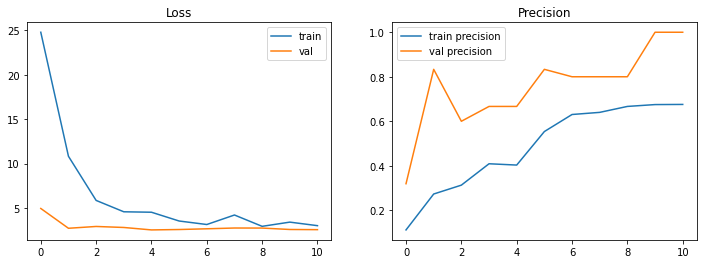

In [ ]:
plot_history(history)

# Visualize the results

In [ ]:
res_vgg = model.evaluate(X_test, y_test)

test_precision_vgg = res_vgg[-1]

print(f"test_precision_vgg = {round(test_precision_vgg,2)*100} %")

print(f'Baseline: {1./num_classes*100:.1f}%')

3/3 [==============================] - 16s 5s/step - loss: 2.4133 - precision_8: 0.8889
test_precision_vgg = 89.0 %
Baseline: 6.7%


In [ ]:
predicted = model.predict(X_test)
# proba = model.predict_proba(X_test)
y_predict_back = np.argmax(predicted, axis=-1)
y_test_back = np.argmax(y_test, axis=-1)

In [ ]:
df_results = pd.DataFrame()

results = []
for code in y_predict_back:
  for products, label in products_encoded.items():
    if code == label:
      results.append(products)

products_to_predict = []
for code in y_test_back:
  for products, label in products_encoded.items():
    if code == label:
      products_to_predict.append(products)

df_results["products_to_predict"] = products_to_predict
df_results["results"] = results

matching = []
for index_ in range(len(df_results["results"])):
  if df_results["products_to_predict"].iloc[index_] == df_results["results"].iloc[index_]:
    matching.append(1)
  else:
    matching.append(0)

df_results["matching"] = matching
df_results["total_number_of_tests"] = 1

df_predictions_results = df_results.groupby('products_to_predict').sum()

matching_percentage = []
for index_ in range(len(df_predictions_results["matching"])):
  matching_percentage.append(round(df_predictions_results["matching"].iloc[index_] / df_predictions_results["total_number_of_tests"].iloc[index_]*100))

df_predictions_results["matching_percentage"] = matching_percentage

df_predictions_results.sort_values(by='matching_percentage', ascending=False)

,matching,total_number_of_tests,matching_percentage
products_to_predict,,,
concombre,6,6,100
pomme_de_terre,4,4,100
banane,3,6,50
ananas,0,6,0
aubergine,0,9,0
brocoli,0,5,0
carotte,0,2,0
citron,0,8,0
gingembre,0,7,0


# Save the model

In [ ]:
from tensorflow import keras
PATH = 'drive/MyDrive/ResNet50_model'
model.save(PATH, save_format='h5')
# loaded_model = keras.models.load_model(PATH)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
